<h1 align=center><font size = 5>Blah, blah, blah</font></h1>

## Introduction

Blah, blah, blah, blah

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Data Cleaning](#0)<br>
2. [Data Preprocessing](#1)<br>
3. [Visualizing Data](#2)<br>
3. [Modeling](#3)<br>
4. [Blah, blah, blah](#4) <br>
</div>
<hr>

In [1]:
spark

In [2]:
#import statements
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import *
from datetime import datetime
from pyspark.sql.types import IntegerType, StructType, StructField, StringType
import time

In [3]:
spark = SparkSession.builder.appName('Final_project').getOrCreate()
#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), 
                                        ('spark.app.name', 'Spark Updated Conf'), 
                                        ('spark.executor.cores', '6'), 
                                        ('spark.cores.max', '4'), ('spark.driver.memory','8g'),
                                       ('spark.sql.autoBroadcastJoinThreshold', '-1'),
                                       ])

sc = spark.sparkContext

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.yarn.jars',
  'local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/jars/*,local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/hive/*'),
 ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.executor.memory', '5g'),
 ('spark.executor.instances', '16'),
 ('spark.lineage.log.dir', '/var/log/spark/lineage'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'md01.rcc.local,md02.rcc.local'),
 ('spark.driver.port', '43972'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.executorEnv.PYTHONPATH',
  '/opt/cloudera/parcels/CDH/lib/spark/python/lib/py4j-0.10.7-src.zip:/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/py4j-0.10.7-src.zip<CPS>/opt/cloudera/parce

In [5]:
#Datapath
path_comments = "/user/rroongseang/bigdata/parquet/comments_parquet/"
path_users = "/user/rroongseang/bigdata/users/"

In [6]:
#Read data
df = sqlContext.read.parquet(path_comments)
users = spark.read.csv(path_users+"RA.2019-09.csv", inferSchema=True, header=True)
botusers = sqlContext.read.csv(path_users+'bot_userdata.csv',header=True)

# Data Cleaning <a id="0"></a>

In [7]:
df.count()

86633134

In [8]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+--------+------+----------------------+-----------------+----+----------------+-----------+-------------+--------+------+---+-------+--------+---------+------------+-----+------------+---------+------------+--------+
|archived|author|author_flair_css_class|author_flair_text|body|controversiality|created_utc|distinguished|   downs|gilded| id|link_id|    name|parent_id|retrieved_on|score|score_hidden|subreddit|subreddit_id|     ups|
+--------+------+----------------------+-----------------+----+----------------+-----------+-------------+--------+------+---+-------+--------+---------+------------+-----+------------+---------+------------+--------+
|66401016|     0|              75695490|         75551029|   0|               0|          0|     84850803|84468358|     0|  0|      0|84468358|        0|       18219|    0|    76923215|        0|           0|69620202|
+--------+------+----------------------+-----------------+----+----------------+-----------+-------------+--------+------+---+--

In [9]:
#dropping several columns with missing and irrelevant data
#subreddit/subreddit_id is the same for all comments since we are only looking in r/politics.
#author flairs are texts + images next to a username that shows up when they post a comment. Most users don't use flairs
#name is a unique identifier that is mostly null.
#id is a unique identifier for the commment and does not add any value to analysis
df = df.drop('archived','author_flair_css_class','author_flair_text',
             'subreddit','subreddit_id','name','score_hidden','id')

In [10]:
#Convert column types to integers and timestamps

df = df.withColumn("ups", df["ups"].cast(IntegerType())) 
df = df.withColumn("downs", df["downs"].cast(IntegerType()))
df = df.withColumn("gilded", df["gilded"].cast(IntegerType()))
df = df.withColumn("score", df["score"].cast(IntegerType()))
df = df.withColumn("retrieved_on", df["retrieved_on"].cast(IntegerType()))
df = df.withColumn("controversiality", df["controversiality"].cast(IntegerType()))
df = df.withColumn('created_utc',df["created_utc"].cast(IntegerType()))
df = df.withColumn('retrieved_on',df["retrieved_on"].cast(IntegerType()))


df = df.withColumn('created_utc',to_timestamp(df["created_utc"]))
df = df.withColumn('retrieved_on',to_timestamp(df["retrieved_on"]))

In [11]:
df.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: integer (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- downs: integer (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: integer (nullable = true)
 |-- ups: integer (nullable = true)



In [12]:
#fill upvote and downvote null values with zeros
df = df.fillna({ 'ups':0, 'downs':0 })

In [13]:
#Rename a user and botuser columns to match for union of dataframe
users = users.selectExpr('id',"name as username", "created_utc as acct_creation",
                         "updated_on","comment_karma","link_karma")

botusers = botusers.selectExpr('username',"post_karma as link_karma", "comment_karma",
                                 "cake_day as acct_creation","is_bot")

In [14]:
import pyspark.sql.functions as f
#Convert account creation and updated on to timestampps
users = users.withColumn('acct_creation',to_timestamp(users["acct_creation"]))
users = users.withColumn('updated_on',to_timestamp(users["updated_on"]))

#Add column is_bot to users dataframe
users = users.withColumn('is_bot',f.lit('False'))

In [15]:
#Cast link karma and comment karma as integer type
#Convert account creation and updated on to timestamps
botusers = botusers.withColumn('link_karma',botusers["link_karma"].cast(IntegerType()))
botusers = botusers.withColumn('comment_karma',botusers["comment_karma"].cast(IntegerType()))
botusers = botusers.withColumn('acct_creation',botusers["acct_creation"].cast(IntegerType()))
botusers = botusers.withColumn('acct_creation',to_timestamp(botusers["acct_creation"]))

In [16]:
#remove rows from user df that exists in botusers
users = users.join(botusers, users.username==botusers.username, "leftanti")

In [17]:
#Append users dataframe with botusers dataframe 
all_users = users.select('username','acct_creation','comment_karma','link_karma','is_bot')\
            .union(botusers.select('username','acct_creation','comment_karma','link_karma','is_bot'))

In [18]:
all_users.printSchema()

root
 |-- username: string (nullable = true)
 |-- acct_creation: timestamp (nullable = true)
 |-- comment_karma: integer (nullable = true)
 |-- link_karma: integer (nullable = true)
 |-- is_bot: string (nullable = true)



In [19]:
#Checking to see if one of the Russian banned accts is in the users list
all_users.filter(all_users.username == 'MiraranaMogra').show()

+-------------+-------------------+-------------+----------+------+
|     username|      acct_creation|comment_karma|link_karma|is_bot|
+-------------+-------------------+-------------+----------+------+
|MiraranaMogra|2015-05-14 09:58:34|          103|      4902|  True|
+-------------+-------------------+-------------+----------+------+



In [20]:
#Combining data frames
df_raw = df.join(all_users, df.author == users.username, 'left')

In [21]:
#Number of comments matched with users dataframe
df_raw.filter(users.username.isNotNull()).count()

69638017

In [22]:
#drop rows where comments authors do not appear in users dataframe
df_raw = df_raw.filter(df_raw.is_bot.isNotNull())
df_raw.count()

69638017

In [23]:
#number of banned account comments in dataframe
df_raw.filter(df_raw.is_bot == 'True').count()

110

# Data Preprocessing <a id="1"></a>

## Pipeline

| <p align="left">**Step**</p>| <p align="left">**Action**</p>|<p align="left">**Example**</p>|
|---|---|---|
| <p align="left">Step 0</p> | <p align="left">Raw Comment</p>  | <p align="left">"Almost 1/3 of registered voters in CA are republican, though..."</p>  |
| <p align="left">Step 1</p> | <p align="left">Put text into lower case</p>  | <p align="left">"almost 1/3 of registered voters in ca are republican, though..."</p>  |
| <p align="left">Step 2</p>  | <p align="left">Remove Non-Text Characters</p>  | <p align="left">"almost of registered voters in ca are republican though"</p> |
| <p align="left">Step 3</p>  | <p align="left">Tokenize Text</p>  | <p align="left">["almost", "of", "registered", "voters", "in", "ca", "are", "republican", "though"]</p> |
| <p align="left">Step 4</p>  | <p align="left">Remove Stopwords</p>  | <p align="left">["almost", "registered", "voters", "ca", "republican"]</p> |
| <p align="left">Step 5</p>  | <p align="left">Stem using Porter Stemmer</p>  | <p align="left">["almost", "regist", "voter", "ca", "republican"]</p>

In [24]:
#Extracting comment posted datetime to new column format HHMMSS
df_raw = df_raw.withColumn('created_time',concat(format_string("%02d",hour(df_raw['created_utc'])),
                                                     format_string("%02d",minute(df_raw['created_utc'])),
                                                     format_string("%02d",second(df_raw['created_utc']))))
df_raw = df_raw.withColumn('created_time',df_raw['created_time'].cast(IntegerType()))

In [25]:
df_raw.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: integer (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- downs: integer (nullable = false)
 |-- gilded: integer (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: integer (nullable = true)
 |-- ups: integer (nullable = false)
 |-- username: string (nullable = true)
 |-- acct_creation: timestamp (nullable = true)
 |-- comment_karma: integer (nullable = true)
 |-- link_karma: integer (nullable = true)
 |-- is_bot: string (nullable = true)
 |-- created_time: integer (nullable = true)



In [26]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def getInterval(time):
    start = int(time)
    return str(start)+"-"+str(start+1)

getIntervalUdf = udf(getInterval,StringType())

df_raw = df_raw.withColumn('year', year(col('created_utc')))
df_raw = df_raw.withColumn('month', month(col('created_utc')))
df_raw = df_raw.withColumn('time', hour(col('created_utc')))

df_raw = df_raw.withColumn("interval",getIntervalUdf("time"))

In [27]:
#remove formatting characters
df_raw = df_raw.withColumn('body_vec', f.regexp_replace('body', "[^a-zA-Z0-9\\s]", ""))

#Next, we will put all letters into lower-case
df_raw = df_raw.withColumn('body_vec', lower(col('body_vec')))

In [28]:
df_raw.show(5)

+------------+--------------------+----------------+-------------------+-------------+-----+------+---------+----------+-------------------+-----+---+------------+-------------------+-------------+----------+------+------------+----+-----+----+--------+--------------------+
|      author|                body|controversiality|        created_utc|distinguished|downs|gilded|  link_id| parent_id|       retrieved_on|score|ups|    username|      acct_creation|comment_karma|link_karma|is_bot|created_time|year|month|time|interval|            body_vec|
+------------+--------------------+----------------+-------------------+-------------+-----+------+---------+----------+-------------------+-----+---+------------+-------------------+-------------+----------+------+------------+----+-----+----+--------+--------------------+
|---JustMe---|Yes. $16 million ...|               0|2016-05-09 17:52:25|         null|    0|     0|t3_4ikml4|t1_d2z41q9|2016-06-12 10:36:52|    4|  4|---JustMe---|2014-02-17 2

In [29]:
from pyspark import keyword_only
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
#import nltk
from nltk.stem.porter import PorterStemmer

#this code courtesy of http://michael-harmon.com/blog/SentimentAnalysisP2.html

class PorterStemming(Transformer, HasInputCol, HasOutputCol):
    """
    PosterStemming class using the NLTK Porter Stemmer
    
    This comes from https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
    Adapted to work with the Porter Stemmer from NLTK.
    """
    
    @keyword_only
    def __init__(self, 
                 inputCol  : str = None, 
                 outputCol : str = None, 
                 min_size  : int = None):
        """
        Constructor takes in the input column name, output column name,
        plus the minimum legnth of a token (min_size)
        """
        # call Transformer classes constructor since were extending it.
        super(Transformer, self).__init__()

        # set Parameter objects minimum token size
        self.min_size = Param(self, "min_size", "")
        self._setDefault(min_size=0)

        # set the input keywork arguments
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

        # initialize Stemmer object
        self.stemmer  = PorterStemmer()

        
    @keyword_only
    def setParams(self, 
                  inputCol  : str = None, 
                  outputCol : str = None, 
                  min_size  : int = None
      ) -> None:
        """
        Function to set the keyword arguemnts
        """
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    

    def _stem_func(self, words  : list) -> list:
        """
        Stemmer function call that performs stemming on a
        list of tokens in words and returns a list of tokens
        that have meet the minimum length requiremnt.
        """
        # We need a way to get min_size and cannot access it 
        # with self.min_size
        min_size       = self.getMinSize()

        # stem that actual tokens by applying 
        # self.stemmer.stem function to each token in 
        # the words list
        stemmed_words  = map(self.stemmer.stem, words)

        # now create the new list of tokens from
        # stemmed_words by filtering out those
        # that are not of legnth > min_size
        filtered_words = filter(lambda x: len(x) > min_size, stemmed_words)

        return list(filtered_words)
    
    def _transform(self, df: DataFrame) -> DataFrame:
        """
        Transform function is the method that is called in the 
        MLPipleline.  We have to override this function for our own use
        and have it call the _stem_func.

        Notice how it takes in a type DataFrame and returns type Dataframe
        """
        # Get the names of the input and output columns to use
        out_col       = self.getOutputCol()
        in_col        = self.getInputCol()

        # create the stemming function UDF by wrapping the stemmer 
        # method function
        stem_func_udf = F.udf(self._stem_func, ArrayType(StringType()))
        
        # now apply that UDF to the column in the dataframe to return
        # a new column that has the same list of words after being stemmed
        df2           = df.withColumn(out_col, stem_func_udf(df[in_col]))

        return df2
  
  
    def setMinSize(self,value):
        """
        This method sets the minimum size value
        for the _paramMap dictionary.
        """
        self._paramMap[self.min_size] = value
        return self

    def getMinSize(self) -> int:
        """
        This method uses the parent classes (Transformer)
        .getOrDefault method to get the minimum
        size of a token.
        """
        return self.getOrDefault(self.min_size)


In [30]:
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover, IDF, StringIndexer
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="body_vec", outputCol="body_vec_token")
remover = StopWordsRemover(inputCol = "body_vec_token", outputCol = "body_vec_token_nosw")
stemmer = PorterStemming(inputCol = "body_vec_token_nosw", outputCol = "body_vec_cleaned")
hashingTF = HashingTF(inputCol="body_vec_cleaned", outputCol="body_vec_tf", numFeatures=100)
idf = IDF(inputCol="body_vec_tf", outputCol="body_vec_tfidf")
label_stringIdx = StringIndexer(inputCol = "is_bot", outputCol = "label")

pipeline = Pipeline(stages=[tokenizer, remover, stemmer, hashingTF,idf, label_stringIdx])

In [31]:
%time nlpdf = pipeline.fit(df_raw).transform(df_raw)

CPU times: user 297 ms, sys: 106 ms, total: 403 ms
Wall time: 31min 58s


In [32]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['controversiality', 'ups', 'downs', 'gilded', 
                                       'created_time', 'comment_karma','link_karma',
                                        'score'], outputCol='features')
nlpdf = assembler.transform(nlpdf)

In [33]:
# nlpdf = df_raw.drop('body_vec')
# nlpdf = df_raw.drop('body_vec_token')
# nlpdf = df_raw.drop('body_vec_token_nosw')
# nlpdf = df_raw.drop('body_vec_cleaned')

In [34]:
nlpdf.select('body_vec_tfidf').show(3)

+--------------------+
|      body_vec_tfidf|
+--------------------+
|(100,[3,18,20,22,...|
|(100,[2,5,6,8,14,...|
|(100,[12,15,30,46...|
+--------------------+
only showing top 3 rows



In [35]:
nlpdf.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: integer (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- downs: integer (nullable = false)
 |-- gilded: integer (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: integer (nullable = true)
 |-- ups: integer (nullable = false)
 |-- username: string (nullable = true)
 |-- acct_creation: timestamp (nullable = true)
 |-- comment_karma: integer (nullable = true)
 |-- link_karma: integer (nullable = true)
 |-- is_bot: string (nullable = true)
 |-- created_time: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- interval: string (nullable = true)
 |-- body_vec: string (nullable = true)
 |-- body_vec_token: array (nullable = true)
 |  

In [36]:
#split data into train and test and ensure label classes are stratified
#train_df_notbanned, test_df_notbanned = nlpdf.filter(nlpdf.label==0).sample(False,0.0001,seed=5).randomSplit([0.8, 0.2])
train_df_notbanned, test_df_notbanned = nlpdf.filter(nlpdf.label==0).randomSplit([0.8, 0.2])
train_df_banned, test_df_banned = nlpdf.filter(nlpdf.label==1).randomSplit([0.8, 0.2])

In [37]:
#unioning training sets and test sets
train_df = train_df_notbanned.union(train_df_banned)
test_df = test_df_notbanned.union(test_df_banned)

In [38]:
# sample_train = train_df.cache()
# sample_test = test_df.cache()

# print("length of training set sample {}".format(sample_train.count()))
# print("length of test set {}".format(sample_test.count()))

# Visualizing Data <a id="2"></a>

## User Posts

In [39]:
from pyspark.sql.functions import year, month, dayofmonth

stats = nlpdf.groupby(
    year('created_utc').alias('year'), 
    month('created_utc').alias('month')).count()

stats.show()

+----+-----+-------+
|year|month|  count|
+----+-----+-------+
|2015|    2| 164878|
|2017|    3|1516490|
|2017|    8|1453742|
|2019|    5|1163775|
|2018|   10|1879269|
|2017|   10|1291906|
|2016|    7|1530511|
|2015|   12| 476057|
|2016|   11|2164820|
|2019|    3|1488005|
|2018|    1|1547581|
|2018|    3|1652388|
|2016|    5|1038273|
|2014|   12|   1002|
|2018|    8|1739689|
|2019|    8|1242755|
|2016|    2|1069072|
|2019|    6|1161263|
|2017|    7|1386928|
|2019|    1|2047938|
+----+-----+-------+
only showing top 20 rows



In [40]:
stats_pdf = stats.toPandas()

In [41]:
stats_pdf.head(5)

,year,month,count
0,2015,2,164878
1,2017,3,1516490
2,2017,8,1453742
3,2019,5,1163775
4,2017,10,1291906


In [42]:
pdf = stats_pdf.sort_values(by=['year', 'month'])

In [43]:
pdf = pdf.reset_index(drop=True)
pdf.head()

,year,month,count
0,2014,12,1002
1,2015,1,181812
2,2015,2,164878
3,2015,3,202011
4,2015,4,207492


In [44]:
# convert into a str with leading 0
pdf['month'] = pdf['month'].apply(str)
pdf['month'] = pdf['month'].str.zfill(2)

pdf.head()

,year,month,count
0,2014,12,1002
1,2015,01,181812
2,2015,02,164878
3,2015,03,202011
4,2015,04,207492


In [45]:
pdf['year'] = pdf['year'].apply(str)
pdf['year_month'] = pdf['year'] + '-' + pdf['month']

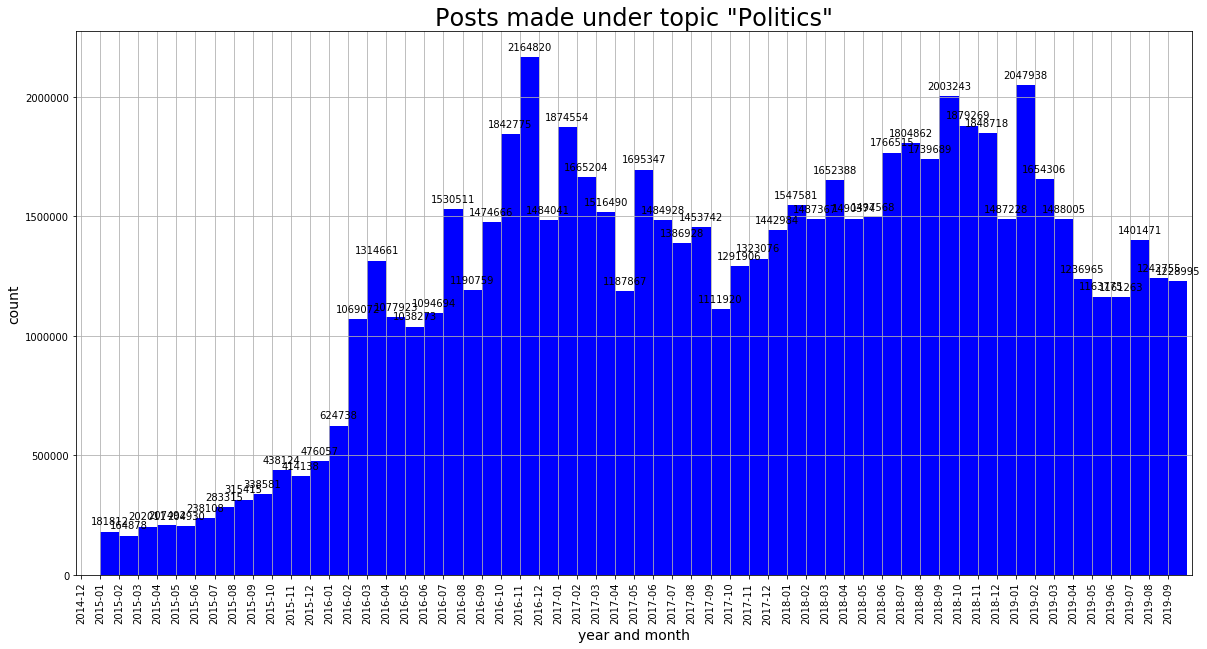

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

ax = pdf.plot(kind='bar', y="count", x='year_month', align='edge', width=1.0, figsize=(20,10), color='blue', legend=False)
ax.grid()
plt.title("Posts made under topic \"Politics\"", size=24)
plt.ylabel("count", size=14)
plt.xlabel("year and month", size=14)

for p in ax.patches:
    if p.get_height() > 150000:
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

## Word Cloud

In [47]:
df_2015_04 = nlpdf.where(nlpdf.year == 2015).where(nlpdf.month == 4)
df_2015_11 = nlpdf.where(nlpdf.year == 2015).where(nlpdf.month == 11)
df_2016_04 = nlpdf.where(nlpdf.year == 2016).where(nlpdf.month == 4)
df_2016_11 = nlpdf.where(nlpdf.year == 2016).where(nlpdf.month == 11)
df_2019_04 = nlpdf.where(nlpdf.year == 2019).where(nlpdf.month == 4)
df_2019_09 = nlpdf.where(nlpdf.year == 2019).where(nlpdf.month == 9)

In [48]:
from pyspark.sql.functions import array_contains, col, explode

df_2015_04 = df_2015_04.select(explode('body_vec_token_nosw').alias('body_vec_token_nosw'))
df_2015_11 = df_2015_11.select(explode('body_vec_token_nosw').alias('body_vec_token_nosw'))
df_2016_04 = df_2016_04.select(explode('body_vec_token_nosw').alias('body_vec_token_nosw'))
df_2016_11 = df_2016_11.select(explode('body_vec_token_nosw').alias('body_vec_token_nosw'))
df_2019_04 = df_2019_04.select(explode('body_vec_token_nosw').alias('body_vec_token_nosw'))
df_2019_09 = df_2019_09.select(explode('body_vec_token_nosw').alias('body_vec_token_nosw'))

In [49]:
word_count_2015_04 = df_2015_04.groupby('body_vec_token_nosw').count()
word_count_2015_11 = df_2015_11.groupby('body_vec_token_nosw').count()
word_count_2016_04 = df_2016_04.groupby('body_vec_token_nosw').count()
word_count_2016_11 = df_2016_11.groupby('body_vec_token_nosw').count()
word_count_2019_04 = df_2019_04.groupby('body_vec_token_nosw').count()
word_count_2019_09 = df_2019_09.groupby('body_vec_token_nosw').count()

In [50]:
word_count_2019_04.orderBy('count', ascending=False).show(21)

+-------------------+-------+
|body_vec_token_nosw|  count|
+-------------------+-------+
|                   |1650454|
|             people| 210709|
|              trump| 203131|
|               like| 169553|
|               dont| 153508|
|              think| 113531|
|                one| 107177|
|                get| 105734|
|                 im| 104274|
|               even|  91968|
|              thats|  91624|
|                see|  89308|
|              right|  82703|
|             report|  81764|
|               know|  78841|
|             please|  76373|
|                 gt|  72850|
|                 us|  72465|
|                hes|  70918|
|               make|  68914|
|              going|  68891|
+-------------------+-------+
only showing top 21 rows



In [51]:
word_count_2015_04_pdf = word_count_2015_04.toPandas()
word_count_2015_11_pdf = word_count_2015_11.toPandas()
word_count_2016_04_pdf = word_count_2016_04.toPandas()
word_count_2016_11_pdf = word_count_2016_11.toPandas()
word_count_2019_04_pdf = word_count_2019_04.toPandas()
word_count_2019_09_pdf = word_count_2019_09.toPandas()

In [52]:
word_count_2019_04_pdf.sort_values('count', ascending=False)[0:21]

,body_vec_token_nosw,count
277034,,1650454
138222,people,210709
45049,trump,203131
209306,like,169553
285096,dont,153508
263913,think,113531
70672,one,107177
256014,get,105734
131742,im,104274
9806,even,91968


In [53]:
wordcloud_2015_04 = word_count_2015_04_pdf.sort_values('count', ascending=False)[1:2001]
wordcloud_2015_11 = word_count_2015_11_pdf.sort_values('count', ascending=False)[1:2001]
wordcloud_2016_04 = word_count_2016_04_pdf.sort_values('count', ascending=False)[1:2001]
wordcloud_2016_11 = word_count_2016_11_pdf.sort_values('count', ascending=False)[1:2001]
wordcloud_2019_04 = word_count_2019_04_pdf.sort_values('count', ascending=False)[1:2001]
wordcloud_2019_09 = word_count_2019_09_pdf.sort_values('count', ascending=False)[1:2001]

In [54]:
# create a dictionary
wordcloud_2015_04 = wordcloud_2015_04.set_index('body_vec_token_nosw').T.to_dict('records')
wordcloud_2015_11 = wordcloud_2015_11.set_index('body_vec_token_nosw').T.to_dict('records')
wordcloud_2016_04 = wordcloud_2016_04.set_index('body_vec_token_nosw').T.to_dict('records')
wordcloud_2016_11 = wordcloud_2016_11.set_index('body_vec_token_nosw').T.to_dict('records')
wordcloud_2019_04 = wordcloud_2019_04.set_index('body_vec_token_nosw').T.to_dict('records')
wordcloud_2019_09 = wordcloud_2019_09.set_index('body_vec_token_nosw').T.to_dict('records')

In [55]:
# install wordcloud
#!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Wordcloud is installed and imported!


In [56]:
# instantiate a word cloud object
comments = WordCloud(
    width=1000,
    height=800,
    background_color='white')

# generate the word cloud
comments.generate_from_frequencies(dict(*wordcloud_2015_04))

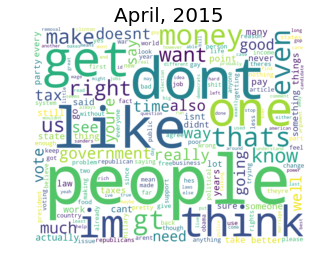

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

# display the word cloud
plt.imshow(comments, interpolation='bilinear')
plt.title('April, 2015', fontsize=20)
plt.axis('off')
plt.show()

In [58]:
# generate the word cloud
comments.generate_from_frequencies(dict(*wordcloud_2015_11))

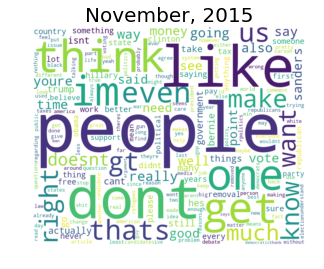

In [59]:
# display the word cloud
plt.imshow(comments, interpolation='bilinear')
plt.title('November, 2015', fontsize=20)
plt.axis('off')
plt.show()

In [60]:
# generate the word cloud
comments.generate_from_frequencies(dict(*wordcloud_2016_04))

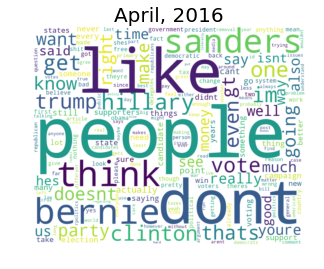

In [61]:
# display the word cloud
plt.imshow(comments, interpolation='bilinear')
plt.title('April, 2016', fontsize=20)
plt.axis('off')
plt.show()

In [62]:
# generate the word cloud
comments.generate_from_frequencies(dict(*wordcloud_2016_11))

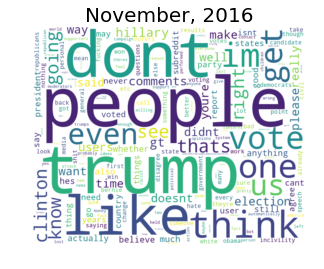

In [63]:
# display the word cloud
plt.imshow(comments, interpolation='bilinear')
plt.title('November, 2016', fontsize=20)
plt.axis('off')
plt.show()

In [64]:
# generate the word cloud
comments.generate_from_frequencies(dict(*wordcloud_2019_04))

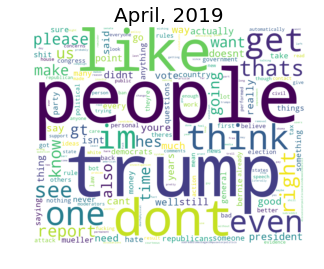

In [65]:
# display the word cloud
plt.imshow(comments, interpolation='bilinear')
plt.title('April, 2019', fontsize=20)
plt.axis('off')
plt.show()

In [66]:
# generate the word cloud
comments.generate_from_frequencies(dict(*wordcloud_2019_09))

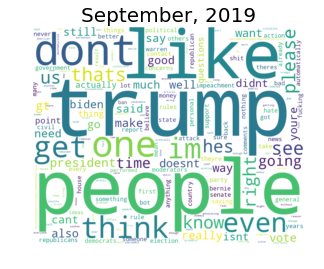

In [67]:
# display the word cloud
plt.imshow(comments, interpolation='bilinear')
plt.title('September, 2019', fontsize=20)
plt.axis('off')
plt.show()

## Posts within time interval bins

In [68]:
df_interval_counts_2015 = nlpdf.where(nlpdf.year == 2015).groupby("year","interval").count()
df_interval_counts_2015.sort(desc("count")).show()

+----+--------+------+
|year|interval| count|
+----+--------+------+
|2015|   11-12|243061|
|2015|   12-13|240079|
|2015|   13-14|228854|
|2015|   10-11|227635|
|2015|   14-15|214541|
|2015|   15-16|201269|
|2015|    9-10|193298|
|2015|   20-21|178594|
|2015|   21-22|177534|
|2015|   16-17|177447|
|2015|   17-18|162848|
|2015|   19-20|158487|
|2015|   18-19|155419|
|2015|   22-23|147201|
|2015|     8-9|137990|
|2015|   23-24|120493|
|2015|     0-1| 98956|
|2015|     7-8| 91817|
|2015|     1-2| 76592|
|2015|     6-7| 59362|
+----+--------+------+
only showing top 20 rows



In [69]:
df_interval_counts_2015_bot = nlpdf.where(nlpdf.year == 2015).where(nlpdf.is_bot == True).groupby("year","interval").count()
df_interval_counts_2015_bot.sort(desc("count")).show()

+----+--------+-----+
|year|interval|count|
+----+--------+-----+
|2015|     4-5|    2|
|2015|     6-7|    2|
|2015|    9-10|    1|
|2015|     7-8|    1|
|2015|   10-11|    1|
|2015|   11-12|    1|
|2015|   12-13|    1|
+----+--------+-----+



In [70]:
df_interval_counts_2016 = nlpdf.where(nlpdf.year == 2016).groupby("year","interval").count()
df_interval_counts_2016.sort(desc("count")).show()

+----+--------+------+
|year|interval| count|
+----+--------+------+
|2016|   11-12|988112|
|2016|   12-13|984122|
|2016|   13-14|968383|
|2016|   10-11|941893|
|2016|   14-15|937796|
|2016|   15-16|916246|
|2016|   20-21|903510|
|2016|   21-22|900891|
|2016|   16-17|850614|
|2016|    9-10|817460|
|2016|   17-18|794468|
|2016|   18-19|766698|
|2016|   19-20|766670|
|2016|   22-23|749137|
|2016|   23-24|618811|
|2016|     8-9|614405|
|2016|     0-1|493736|
|2016|     7-8|414133|
|2016|     1-2|376018|
|2016|     6-7|271086|
+----+--------+------+
only showing top 20 rows



In [71]:
df_interval_counts_2016_bot = nlpdf.where(nlpdf.year == 2016).where(nlpdf.is_bot == True).groupby("year","interval").count()
df_interval_counts_2016_bot.sort(desc("count")).show()

+----+--------+-----+
|year|interval|count|
+----+--------+-----+
|2016|    9-10|   23|
|2016|     8-9|   12|
|2016|   12-13|   11|
|2016|     7-8|   11|
|2016|   13-14|    6|
|2016|     5-6|    5|
|2016|     4-5|    4|
|2016|   11-12|    4|
|2016|   18-19|    3|
|2016|   14-15|    3|
|2016|   21-22|    2|
|2016|   10-11|    2|
|2016|   17-18|    2|
|2016|     3-4|    2|
|2016|   20-21|    2|
|2016|     6-7|    2|
|2016|   19-20|    2|
|2016|   16-17|    1|
+----+--------+-----+



In [74]:
df_interval_counts_2017 = nlpdf.where(nlpdf.year == 2017).groupby("year","interval").count()
df_interval_counts_2017.sort(desc("count")).show()

+----+--------+-------+
|year|interval|  count|
+----+--------+-------+
|2017|   11-12|1187507|
|2017|   12-13|1180951|
|2017|   13-14|1148985|
|2017|   14-15|1132771|
|2017|   10-11|1118256|
|2017|   15-16|1087267|
|2017|    9-10| 991809|
|2017|   16-17| 986846|
|2017|   17-18| 913330|
|2017|   18-19| 852710|
|2017|   19-20| 810646|
|2017|   20-21| 795605|
|2017|     8-9| 790688|
|2017|   21-22| 759598|
|2017|   22-23| 669879|
|2017|   23-24| 551026|
|2017|     7-8| 537723|
|2017|     0-1| 436517|
|2017|     6-7| 333934|
|2017|     1-2| 331398|
+----+--------+-------+
only showing top 20 rows



In [75]:
df_interval_counts_2017_bot = nlpdf.where(nlpdf.year == 2017).where(nlpdf.is_bot == True).groupby("year","interval").count()
df_interval_counts_2017_bot.sort(desc("count")).show()

+----+--------+-----+
|year|interval|count|
+----+--------+-----+
|2017|     8-9|    1|
|2017|   10-11|    1|
+----+--------+-----+



In [76]:
df_interval_counts_2018 = nlpdf.where(nlpdf.year == 2018).groupby("year","interval").count()
df_interval_counts_2018.sort(desc("count")).show()

+----+--------+-------+
|year|interval|  count|
+----+--------+-------+
|2018|   12-13|1368603|
|2018|   14-15|1351920|
|2018|   13-14|1350353|
|2018|   11-12|1344167|
|2018|   15-16|1305702|
|2018|   10-11|1258470|
|2018|   16-17|1185074|
|2018|    9-10|1126928|
|2018|   17-18|1081710|
|2018|   18-19|1001779|
|2018|   19-20| 936702|
|2018|     8-9| 925377|
|2018|   20-21| 918841|
|2018|   21-22| 864625|
|2018|   22-23| 751912|
|2018|     7-8| 654964|
|2018|   23-24| 617660|
|2018|     0-1| 478739|
|2018|     6-7| 404610|
|2018|     1-2| 355041|
+----+--------+-------+
only showing top 20 rows



In [77]:
df_interval_counts_2018_bot = nlpdf.where(nlpdf.year == 2018).where(nlpdf.is_bot == True).groupby("year","interval").count()
df_interval_counts_2018_bot.sort(desc("count")).show()

+----+--------+-----+
|year|interval|count|
+----+--------+-----+
+----+--------+-----+



In [78]:
df_interval_counts_2019 = nlpdf.where(nlpdf.year == 2019).groupby("year","interval").count()
df_interval_counts_2019.sort(desc("count")).show()

+----+--------+------+
|year|interval| count|
+----+--------+------+
|2019|   12-13|871321|
|2019|   11-12|859742|
|2019|   13-14|853500|
|2019|   14-15|819779|
|2019|   10-11|803729|
|2019|   15-16|795709|
|2019|   16-17|735608|
|2019|    9-10|719419|
|2019|   17-18|658204|
|2019|   18-19|606291|
|2019|   20-21|587977|
|2019|     8-9|585483|
|2019|   19-20|584592|
|2019|   21-22|545736|
|2019|   22-23|456242|
|2019|     7-8|414936|
|2019|   23-24|367976|
|2019|     0-1|283406|
|2019|     6-7|265816|
|2019|     1-2|216249|
+----+--------+------+
only showing top 20 rows



In [79]:
df_interval_counts_2019_bot = nlpdf.where(nlpdf.year == 2019).where(nlpdf.is_bot == True).groupby("year","interval").count()
df_interval_counts_2019_bot.sort(desc("count")).show()

+----+--------+-----+
|year|interval|count|
+----+--------+-----+
|2019|     4-5|    1|
|2019|     8-9|    1|
+----+--------+-----+



#### Modeling <a id="3"></a>

In [38]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
start = time.time()
# Set parameters for Logistic Regression
lgr = LogisticRegression(maxIter=10, featuresCol = 'body_vec_tfidf', labelCol='label')

# Fit the model to the data.
lgrm = lgr.fit(train_df)
#lgrm = lgr.fit(sample_train)
end = time.time()
print('time to run: {}'.format(end - start))

time to run: 8.967144966125488


In [39]:
start = time.time()
# Given a dataset, predict each point's label, and show the results.
predictions = lgrm.transform(test_df)
#predictions = lgrm.transform(sample_test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print('prediction accuracy: {}'\
          .format(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))
print('prediction f1 score: {}'\
          .format(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))
end = time.time()
print('time to run: {}'.format(end - start))

prediction accuracy: 0.9626168224299065
prediction f1 score: 0.9626168224299065
time to run: 2.2132484912872314


In [40]:
# y_true = predictions.select('label').collect()
# y_pred = predictions.select('prediction').collect()
# true_list = [result.label for result in y_true]
# pred_list = [result.prediction for result in y_pred]

In [42]:
# from sklearn.metrics import classification_report, confusion_matrix
# print(classification_report(true_list, pred_list))

             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98       105
        1.0       0.00      0.00      0.00         2

avg / total       0.96      0.96      0.96       107



In [43]:
from pyspark.ml.classification import RandomForestClassifier
# Set parameters for the Random Forest.
rfc = RandomForestClassifier(maxDepth=5, numTrees=15, impurity="gini", featuresCol='features',
                             labelCol="label")

# Fit the model to the data.
rfcm = rfc.fit(train_df)

# Given a dataset, predict each point's label, and show the results.
rfpredictions = rfcm.transform(test_df)

In [47]:
print('prediction accuracy: {}'\
          .format(evaluator.evaluate(rfpredictions, {evaluator.metricName: "accuracy"})))
print('prediction f1 score: {}'\
          .format(evaluator.evaluate(rfpredictions, {evaluator.metricName: "f1"})))

prediction accuracy: 1.0
prediction f1 score: 1.0


In [48]:
# y_true = rfpredictions.select('label').collect()
# y_pred = rfpredictions.select('prediction').collect()
# true_list = [result.label for result in y_true]
# pred_list = [result.prediction for result in y_pred]

In [49]:
# from sklearn.metrics import classification_report, confusion_matrix
# print(classification_report(true_list, pred_list))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       105
        1.0       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00       107



# Blah, blah, blah <a id="4"></a>